# Notebook 1: Linear decoders

In [69]:
from IPython.display import Audio, display, Image
from scipy.signal import hilbert
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
from mne.filter import filter_data
import h5py
from pipeline.ridge import Ridge
import pickle

np.random.seed(0)

# Intro

In this tutorial we will be using EEG data that was recorded whilst a participant attended to continuous speech (in the form of audiobooks). Below is an example of a typical experimental setup used to acquire this sort of data, as well as an example audiobook from our dataset.

<img src="../images/cnsp_experiment.png" width="400"/>

In [71]:
sound_file = '../data/AUNP01.wav'
srate, speech = wavfile.read(sound_file)
wn = Audio(sound_file, autoplay=True, rate=srate)
display(wn)

We can study what features of the stimulus are encoded in the EEG recordings by attempting to reconstruct (or decode) them:

<img src="../images/cnsp_bw_model.png" width="800"/>

The speech envelope (essentially the amplitude) turns out to be rather strongly encoded in EEG recordings. You can see how the speech envelope relates the the original waveform below:m

Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 4225 samples (0.264 sec)



Text(0.5, 1.0, 'Plot of stimulus and stimulus envelope')

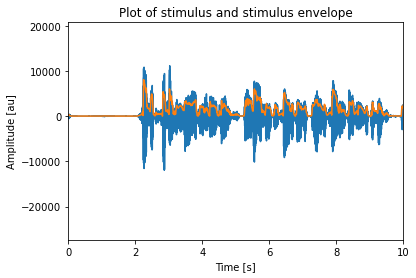

In [81]:
def get_envelope(x, fs):
    envelope = np.abs(hilbert(x))
    return filter_data(envelope, fs, None, 50)

t = np.arange(len(speech))/srate
plt.plot(t, speech, label = 'speech')
plt.plot(t, get_envelope(speech, srate), label = 'speech envelope')
plt.xlim(0, 10)

plt.xlabel('Time [s]')
plt.ylabel('Amplitude [au]')
plt.title('Plot of stimulus and stimulus envelope')

In the linear decoding approach, we take a linear combination (or weighted sum) of the EEG recordings within a certain time window in order to predict the speech envelope at the start of the window:

<img src="../images/cnsp_maths.png" width="800"/>

The traditional method for finding the optimal weights/parameters is ridge regression. This is implemented in popular toolboxes such as the mTRF toolbox and mne-Python. We also provide an implementation which will be explored in this notebook. The famous formula for the ridge parameters is as follows:

<img src="../images/cnsp_ridge.png" width="400"/>

# Data, availability, and preprocessing

In the tutorial we will use EEG data recorded from 13 participants. Each participant listened to a single speaker narrate audiobook chapters in English. There were 15 trials per participant. Full details of the data acquisition procedure are given in [Hugo's paper](https://direct.mit.edu/jocn/article-abstract/32/1/155/95401/Cortical-Tracking-of-Surprisal-during-Continuous).

A version of this dataset is freely available on [figshare](https://figshare.com/projects/Cortical_Tracking_of_Surprisal_during_Continuous_Speech_Comprehension/66596). If you are interested in using the unprocessed dataset for your research, feel free to contact me at mdt20@ic.ac.uk. We plan to release the unprocessed recordings, as well as another dataset with more interesting stimuli, in the near future.

The EEG data used in this tutorial has already been preprocessed. You can find details of the preprocessing procedure in our paper, as well as in the `data_preprocessing` directory in this repository. The sampling rate of the preprocessed data is 125 Hz, and the EEG data have been filtered between 0.5 Hz and 8 Hz. We have used broadband stimulus envelopes, lowpass filtered below 50 Hz.

The frequency ranges of the data are verified for one of the participants below:

In [82]:
with h5py.File('/media/mdt20/Storage/data/mldecoders/data/hugo/0.5-8Hz/data.h5', 'r') as f:
    eeg = f['eeg/P00/part1'][:]
    envelope = f['stim/part1'][:]

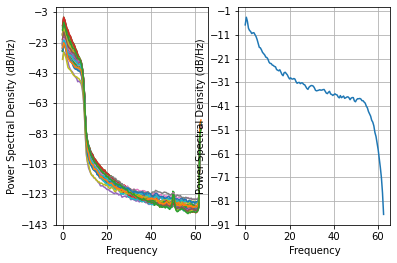

In [83]:
fig, axs = plt.subplots(1,2)

for i in range(63): 
    axs[0].psd(eeg[i], Fs=125);
    
axs[1].psd(envelope, Fs=125);

# Linear models

We would like to relate the EEG recordings to the speech envelopes. One way of doing this is via backward modelling, otherwise known is stimulus-reconstruction. We will begin by using an approach which is similar to the TRF model, but predicts the speech envelope given a temporal context of EEG recordings using a linear filter.

We will fit the linear filter via ridge regression, which is common practice in the field. We will use the first nine story parts as training data, the next 3 as validation data for tuning the regularisation parameter, and the final 3 as testing data. We could also have chosen to perform cross-validation here.

## Fitting a linear model for a single participant

First, we go over fitting a linear model in detail, for a single participant. We choose the first participant (0) by default.

We will use nine EEG trials to fit the model parameters via ridge regression. Three trials will be used for 'validation' - that is, for choosing the regularisation hyperparameter $\lambda$. The remaining three trials will be used to evaulate the fit with the chosen hyperparameter.

In [99]:
participant = 0
data_dir = '/media/mdt20/Storage/data/mldecoders/data/hugo/0.5-8Hz/data.h5'

train_parts = range(9)
val_parts = range(9,12)
test_parts = range(12, 15)

# try 15 regularisation parameters spaced evenly on a log scale between 1e-7 and 1e7
regularisation_parameters = np.logspace(-7, 7, 15)

Concatenating the trials in the training, validation, and testing datasets, respectively:

In [100]:
with h5py.File(data_dir, 'r') as f:
    X_train = np.hstack([f[f'eeg/P0{participant}/part{j}'][:] for j in train_parts])
    y_train = np.hstack([f[f'stim/part{j}'][:] for j in train_parts])
    
    X_val = np.hstack([f[f'eeg/P0{participant}/part{j}'][:] for j in val_parts])
    y_val = np.hstack([f[f'stim/part{j}'][:] for j in val_parts])
    
    X_test = np.hstack([f[f'eeg/P0{participant}/part{j}'][:] for j in test_parts])
    y_test = np.hstack([f[f'stim/part{j}'][:] for j in test_parts])

To fit the model, we have to state the number of lags used in the spatiotemporal window, which is 50 in this case. We can also set an offset between the start of the window and the predicted envelope value, which is defined by `start_lag`. This is set to zero here, since we assume causality. This parameter is useful for fitting encoding models.

In [101]:
# declare the model
mdl = Ridge(start_lag=0, end_lag=50, alpha=regularisation_parameters)

# fit the model parameters via ridge regression, for all regularisation parameters
mdl.fit(X_train.T, y_train[:, np.newaxis])

# evaluate the model on the validation dataset for every regularisation parameter, and select the best value
val_scores = mdl.model_selection(X_val.T, y_val[:, np.newaxis])

# test the model on the test dataset
test_score = mdl.score(X_test.T, y_test[:, np.newaxis])[0]

Checking inputs...
Formatting data matrix...
Calculating coefficients...


Best regularisation parameter:  0.1
Test score (correlation): 0.1827893349787686


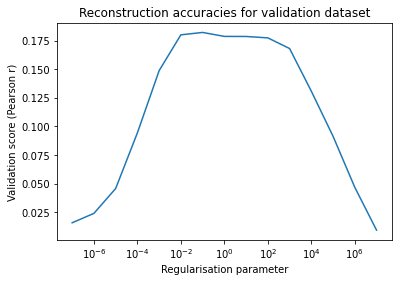

In [102]:
plt.plot(regularisation_parameters, val_scores)
plt.xscale('log')

plt.title('Reconstruction accuracies for validation dataset')
plt.ylabel('Validation score (Pearson r)')
plt.xlabel('Regularisation parameter')

print('Best regularisation parameter: ', mdl.alphas[mdl.best_alpha_idx])
print('Test score (correlation):', test_score)

## Fitting linear models for all participants

Now we're ready to fit linear decoders for all of the participants! In the following cell, you can also see how the trained linear models and their predictions are saved to disk for use later. We also obtain 'null scores', which are explained next.

In [103]:
test_scores = []
null_scores = []

with h5py.File('/media/mdt20/Storage/data/mldecoders/data/hugo/0.5-8Hz/data.h5', 'r') as f:
    
    mdl = Ridge(start_lag=0, end_lag=50, alpha=regularisation_parameters)

    for participant in range(13):
        
        print('Fitting model for participant:', participant)
        
        # training using all regularisation parameters
        X_train = np.hstack([f[f'eeg/P0{participant}/part{j}'][:] for j in train_parts])
        y_train = np.hstack([f[f'stim/part{j}'][:] for j in train_parts])
        mdl.fit(X_train.T, y_train[:, np.newaxis])
        
        # select best regularisation parameter
        X_val = np.hstack([f[f'eeg/P0{participant}/part{j}'][:] for j in val_parts])
        y_val = np.hstack([f[f'stim/part{j}'][:] for j in val_parts])
        val_scores = mdl.model_selection(X_val.T, y_val[:, np.newaxis])
        
        # save the trained model
        pickle.dump(mdl, open(f"../results/linear_models/P{participant:02d}_ridge.pk", "wb"))
        
        # get and save predicted speech envelope
        X_test = np.hstack([f[f'eeg/P0{participant}/part{j}'][:] for j in test_parts])
        y_test = np.hstack([f[f'stim/part{j}'][:] for j in test_parts])
        
        test_predictions = mdl.predict(X_test.T)
        np.save(f"../results/linear_models/P{participant:02d}_predictions.npy", test_predictions)
        
        # compute the correlation between the predictions and the true speech envelope
        test_score = mdl.score(X_test.T, y_test[:, np.newaxis])[0]
        test_scores.append(test_score)
        
        # compute the null correlations
        null_score = mdl.score(X_test.T, y_test[::-1, np.newaxis])[0]
        null_scores.append(null_score)

Fitting model for participant: 0
Checking inputs...
Formatting data matrix...
Calculating coefficients...
Fitting model for participant: 1
Checking inputs...
Formatting data matrix...
Calculating coefficients...
Fitting model for participant: 2
Checking inputs...
Formatting data matrix...
Calculating coefficients...
Fitting model for participant: 3
Checking inputs...
Formatting data matrix...
Calculating coefficients...
Fitting model for participant: 4
Checking inputs...
Formatting data matrix...
Calculating coefficients...
Fitting model for participant: 5
Checking inputs...
Formatting data matrix...
Calculating coefficients...
Fitting model for participant: 6
Checking inputs...
Formatting data matrix...
Calculating coefficients...
Fitting model for participant: 7
Checking inputs...
Formatting data matrix...
Calculating coefficients...
Fitting model for participant: 8
Checking inputs...
Formatting data matrix...
Calculating coefficients...
Fitting model for participant: 9
Checking inpu

## Results

In the last two lines of the above cell, we computed 'null scores' by time-reversing the true speech envelope and correlating it against the predicted speech envelope. Since there should be no systematic correlation between the predicted speech envelope and the time-reversed speech envelope, the resulting 'null scores' allow us to estimate the noise level of the reconstruction scores (Pearson correlation coefficients). This allows us to assess whether the reconstruction scores are due to chance correlations, or whether the speech envelope really can be decoded from the EEG recordings.

The reconstruction scores and null scores for each participant are plotted below:

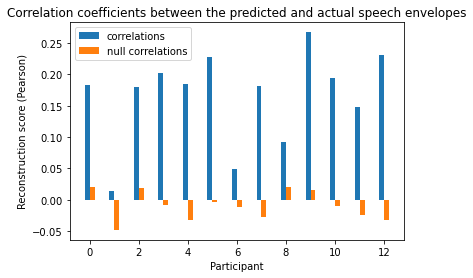

In [104]:
width = .2
x = np.arange(13)
plt.bar(x-width/2, test_scores, width=width, label='correlations')
plt.bar(x+width/2, null_scores, width=width, label='null correlations')

plt.title("Correlation coefficients between the predicted and actual speech envelopes")
plt.ylabel('Reconstruction score (Pearson)')
plt.xlabel("Participant")
plt.legend()

We should check that the reconstruction scores are significantly different to the null distribution. We can do this with a t-test. The p-value turns out to be quite significant:

In [105]:
from scipy.stats import ttest_ind
print(ttest_ind(test_scores, null_scores, alternative='greater'))

Ttest_indResult(statistic=8.230621537739136, pvalue=9.507031987860824e-09)


# Envelope decoding for BCI applications

It has been shown that speech envelope decoding can be used to decode auditory attention. It turns out that the reconstruction score of an attended speech envelope is greater than that of an unattended speech envelope. We say that the reconstruction score is modulated by selective attention.

This effect can be measured in experiments whereby the participants are presented with two audiobooks simultaneously, and asked to attend to one whilst ignoring the other. An example of what the results might look like is shown below:

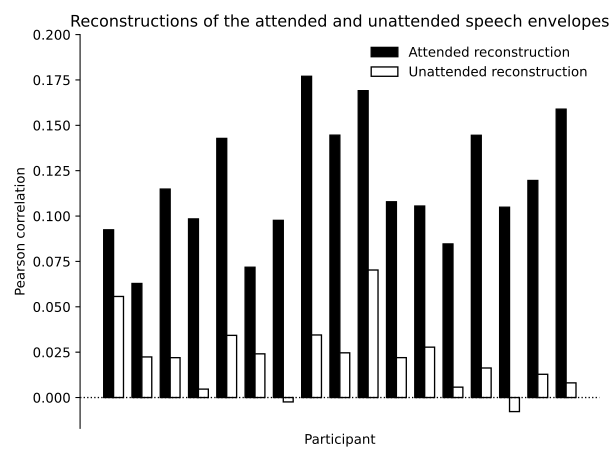

In [27]:
img = Image('../images/two-speaker-recon.png', width=500, height=250)
display(img)

We won't move onto two-speaker data in this tutorial, but the techniques used in competing-speakers scenarios are essentially the same as those used in this notebook.

It has been proposed that attention decoding can be used to enhance hearing aids, by suppressing ignored speech streams and enhancing attended speech streams. In order to work in real-time, we need to be able to decode the speech envelopes in small windows, instead of across the entire trial. Let's see what this looks like for the first participant:

In [33]:
participant = 0

with h5py.File('/media/mdt20/Storage/data/mldecoders/data/hugo/0.5-8Hz/data.h5', 'r') as f:
    envelopes = np.hstack([f[f'stim/part{j}'][:] for j in test_parts])
    
predictions = np.load(f'../results/linear_models/P{participant:02d}_predictions.npy')

0.13275851635282326
0.2692797828311666


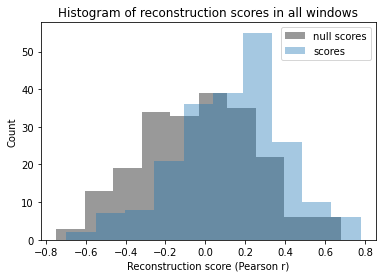

In [54]:
from pipeline.helpers import get_scores

# the get_scores function splits the data into windows of size batch_size.
# Since the sampling rate is 125 Hz, a batch_size of 250 corresponds to a window duration of 2 s.
scores = get_scores(envelopes, predictions[0], batch_size=250)

# we can also obtain null scores by correlating the envelope predictions in one window with the actual envelope from another.
# this is done by setting the null flag equal to true:
null_scores = get_scores(envelopes, predictions[0], batch_size=250, null=True)

plt.hist(null_scores, color='black', alpha=0.4, label='null scores')
plt.hist(scores, alpha=0.4, label='scores')
plt.legend()

plt.title('Histogram of reconstruction scores in all windows')
plt.ylabel('Count')
plt.xlabel('Reconstruction score (Pearson r)')

In [57]:
print("mean reconstruction score:", np.mean(scores))
print("standard deviation of reconstruction score: ", np.std(scores), "\n")

print("mean null reconstruction score:", np.mean(null_scores))
print("standard deviation of null reconstruction score: ", np.std(null_scores))

mean reconstruction score: 0.13275851635282326
standard deviation of reconstruction score:  0.2692797828311666 

mean null reconstruction score: -0.02965868098912545
standard deviation of null reconstruction score:  0.28691987691175075


We see that by using a small window to compute the correlation coefficient between the actual speech envelope and the reconstruction, we end up with rather noisy estimates. The mean reconstruction score is similar to the trial-wise correlation coefficients, but the standard deviation is vary large compared to the mean. We had better check that these reconstruction scores are significantly different to the null scores:

In [60]:
from scipy.stats import ttest_ind

print(ttest_ind(scores, null_scores, alternative='greater'))

Ttest_indResult(statistic=5.967207262977777, pvalue=2.57574063770462e-09)


In the next notebook, we will investigate how deep neural networks might be used to improve the mean envelope reconstruction score (pearson correlation coefficient).

# Exercise: investigate how the mean and standard deviation of the reconstruction scores vary with window size, for a few participants.